## Obligatorio de Deep Learning - Semestre 2 - 2022

## 1. Setup

### 1.1 Imports

In [111]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")


In [113]:
!ls

 data
'Deep Learning - Obligatorio 2022.pdf'
 kaggle_data
 outputs
 __pycache__
 Referencias.gdoc
'Template HDFS Log Classification.ipynb'
 utils.py


In [114]:
import numpy as np
import datetime as dt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from importlib import reload
import utils
utils = reload(utils)

### 1.2 Set random seeds

In [115]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [116]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [117]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [118]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### 3.1 Análisis descriptivo general: Distribuciones, Scatterplots, Barplots...

In [119]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


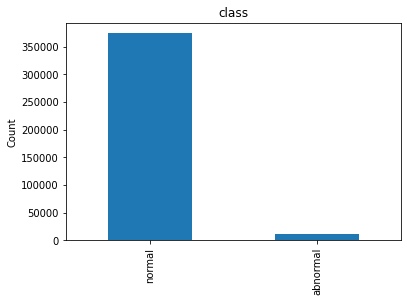

In [120]:
utils.value_counts(hdfs_train,'class')

### 3.2 Análisis de secuencias

In [121]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [122]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)
#raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
try:
    data_y.value_counts()
except:
    pass

In [124]:
min([min(s) for s in raw_sequences])

1

In [125]:
max([max(s) for s in raw_sequences])

28

In [126]:
np.median([len(s) for s in raw_sequences])

19.0

### Padding

In [127]:
max_len = 19
padded_sequences = utils.pad_sequences(raw_sequences, max_len)

# Data preprocessing


## Particionamiento

In [128]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)


## X_train_aug Data Augmentation

In [20]:
X_train_for_aug, a, b, c, d, e = utils.split(raw_sequences, data_y)


In [21]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, max_len, 19)

In [22]:
"""
padding to data augmentation traing
"""
X_train_aug = utils.pad_sequences(X_train_aug, max_len)


#Language Model

## Modelo Inicial

In [40]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
max_len = 19
batch_size = 10
epochs = 1
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [41]:
initial_model = Sequential()
initial_model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
initial_model.add(LSTM(64, return_sequences=False))
initial_model.add(Dense(2, activation='softmax'))
initial_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_6 (LSTM)               (None, 64)                17408     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [43]:
#se agregó class.weights
initial_training, initial_model = utils.train(initial_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

26007/26007 [==============================] - 335s 13ms/step - loss: 0.0558 - accuracy: 0.9895 - val_loss: 0.0110 - val_accuracy: 0.9988


### Evaluation

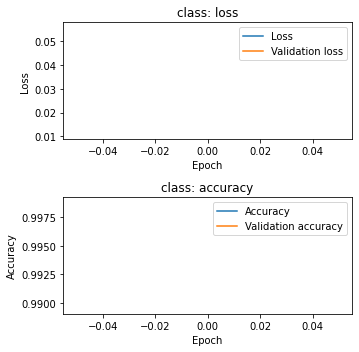

3011/3011 [==============================] - 17s 5ms/step


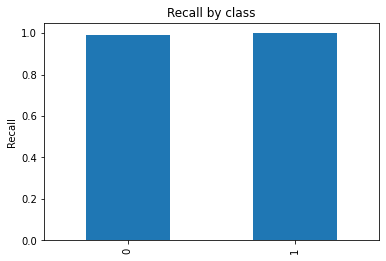

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.012469988316297531, accuracy: 0.998629629611969


In [129]:
utils.eval_model(initial_training, initial_model, X_test, y_test)

## Modelo Mejorado

In [34]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
max_len = 19
batch_size = 24
epochs = 7
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [35]:
improved_model = Sequential()
improved_model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
improved_model.add(LSTM(64, return_sequences=True))
improved_model.add(LSTM(64, return_sequences=False))
improved_model.add(Dense(2, activation='softmax'))
improved_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
improved_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_4 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,652
Trainable params: 50,652
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [36]:
#se agregó class.weights
improved_training, improved_model = utils.train(improved_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
10837/10837 [==============================] - 273s 25ms/step - loss: 0.0457 - accuracy: 0.9930 - val_loss: 0.0078 - val_accuracy: 0.9988
Epoch 2/7
10837/10837 [==============================] - 261s 24ms/step - loss: 0.0151 - accuracy: 0.9984 - val_loss: 0.0102 - val_accuracy: 0.9988
Epoch 3/7
10837/10837 [==============================] - 263s 24ms/step - loss: 0.0127 - accuracy: 0.9985 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 4/7
10837/10837 [==============================] - 262s 24ms/step - loss: 0.0099 - accuracy: 0.9986 - val_loss: 0.0095 - val_accuracy: 0.9988
Epoch 5/7
10837/10837 [==============================] - 290s 27ms/step - loss: 0.0092 - accuracy: 0.9989 - val_loss: 0.0043 - val_accuracy: 0.9992
Epoch 6/7
10837/10837 [==============================] - 264s 24ms/step - loss: 0.0096 - accuracy: 0.9988 - val_loss: 0.0058 - val_accuracy: 0.9991
Epoch 7/7
10837/10837 [==============================] - 264s 24ms/step - loss: 0.0094 - accuracy: 0.9989 - val_

### Evaluation

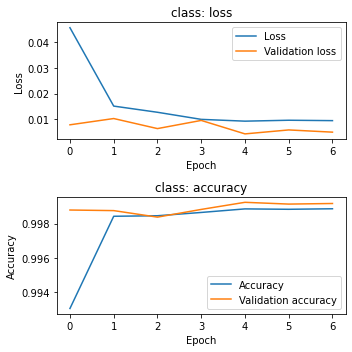

3011/3011 [==============================] - 29s 10ms/step


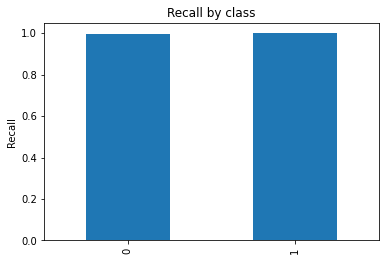

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323



In [ ]:
utils.eval_model(improved_training, improved_model, X_test, y_test)

##Grid Search



In [ ]:
vocab_size = 30
max_len = 19
batch_size = 32
epochs = 20
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = 3

### Model Mejorado 

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_4 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/20
8128/8128 [==============================] - 229s 28ms/step - loss: 0.0547 - accuracy: 0.9917 - precision_2: 0.9917 - recall_2: 0.9917 - val_loss: 0.0172 - val_accuracy: 0.9962 - val_precision_2: 0.9962 - val_recall_2: 0.9962
Epoch 2/20
8128/8128 [==============================] - 222s 27ms/step - loss: 0.0151 - accuracy: 0.9975 - precision_2: 0.9975 - recall_2: 0.9975 - val_loss: 0.0103 - val_accuracy: 0.9985 - val_precision_2: 0.9985 - val_recall_2: 0.9985
Epoch 3/20
8128/8128 [==============================] - 220s 27ms/step - loss: 0.0139 - accuracy: 0.9978 - precision_2: 0.9978 - recall_2: 0.9978 - val_loss: 0.0055 - val_accuracy: 0.9988 - val_precision_2: 0.9988 - val_recall_2: 0.9988
Epoch 4/20
8128/8128 [==============================] - 217s 27ms/step - loss: 0.0108 - accuracy: 0.9982 - precision_2: 0.9982 - recall_2: 0.9982 - val_loss: 0.0066 - val_accuracy: 0.9988 - val_precision_2: 0.9988 - val_recall_2: 0.9988
Epoch 5/20
8128/8128 [==============================

#### Evaluation

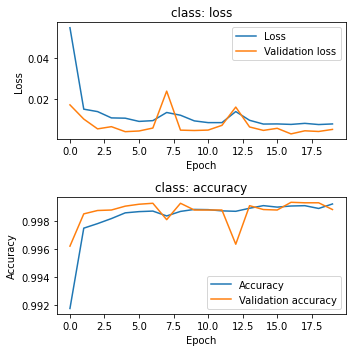

3011/3011 [==============================] - 27s 9ms/step


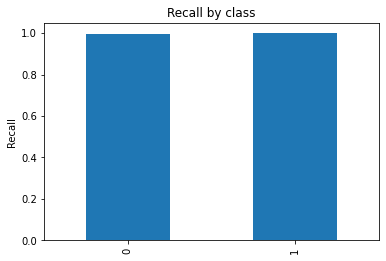

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.005683504976332188, accuracy: 0.9986711144447327


In [ ]:
utils.eval_model(training, model, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 50s 8ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelBN.add(LSTM(64, return_sequences=True))
modelBN.add(LSTM(64, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelBN.summary()

AttributeError: ignored

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingBN, modelBN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Gradient Clipping

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC.add(LSTM(64, return_sequences=True))
modelGC.add(LSTM(64, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingGC, modelGC, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


### Modelo Mejorado con Batch Normalization y Gradient Clipping

In [ ]:
modelGC_BN = Sequential()
modelGC_BN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC_BN.add(LSTM(64, return_sequences=True))
modelGC_BN.add(LSTM(64, return_sequences=False))
modelGC_BN.add(BatchNormalization())
modelGC_BN.add(Dense(2, activation='softmax'))
modelGC_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC_BN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC_BN, modelGC_BN = utils.train(modelGC_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingGC_BN, modelGC_BN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGCandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGC_BN, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Data Augmentation

In [ ]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelDA.add(LSTM(64, return_sequences=True))
modelDA.add(LSTM(64, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.F1Score()])
modelDA.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluation

In [ ]:
utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

## 6 Consigna

### A) Participación en Competencia Kaggle:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Macro Average Recall (o Weighted Accuracy) superior al 80%. [->Link a la competencia<-](https://www.kaggle.com/t/6d15e3a96bd049b2b4b2a491a69a0fc7).

### B) Utilización de Grid Search (o equivalente):
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible.

### C) Se debe a su vez investigar e implementar al menos 2 de las siguientes técnicas:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Data Augmentation a través de la realización de Windowing](https://blog.finxter.com/how-to-loop-through-a-python-list-in-batches/#Method_1_Iterating_over_Consecutive_Sliding_Windows)
#### 3. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)
